In [2]:
root = '/Users/billystrickland/Documents/code/resonators/data/'
import matplotlib.pyplot as plt
import numpy as np

import shabanipy.resonators.billys_code.utils.resonator_functions as rf

from shabanipy.resonators.billys_code.utils.jy_mpl_settings.settings import jy_mpl_rc
from shabanipy.resonators.billys_code.utils.jy_mpl_settings.colors import line_colors

from scipy.optimize import curve_fit

plt.style.use(jy_mpl_rc)

from scipy.special import kn, iv

kb = 8.617e-5         # Boltzmanns constant in units eV/Kelvin
h = 4.136e-15         # Plancks constant in units of eV s
    
def sigma1(T, d, f):
    return (4* d/(h * f)*np.exp(-d/kb/T)*np.sinh(h*f/2/kb/T))*kn(0,h*f/2/kb/T)

def sigma2(T, d, f):
    return (np.pi*d/(h*f)*(1-np.sqrt(2*np.pi*kb*T/d)*np.exp(-d/(kb*T))-2*np.exp(-d/(kb*T))*np.exp(-h*f/(2*kb*T))*iv(0, h*f/(2*kb*T))))

def phi(T, d, f):
    return np.arctan(sigma2(T, d, f)/sigma1(T, d, f))

def func_deltafoverf(T, a, d, f):
    # a is the kinetic inductance fraction
    return -a/2*(1-np.sin(phi(T, d, f))*np.sqrt((sigma1(T, d, f)**2+ sigma2(T, d, f)**2)/ ((sigma1(0.001, d, f)**2+ sigma2(0.001, d, f)**2))))

[0.05151681 0.00091555] [0.07567271 0.00014294]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$T$ (K)', ylabel='$\\delta f_r/f_r$ (ppm)'>)

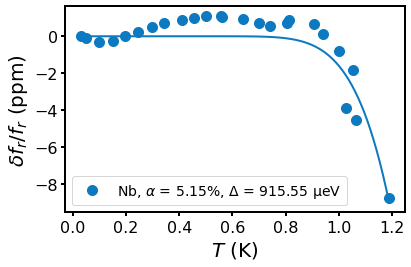

In [3]:



sample = 'InP-Nb_LO-7barresonators-v1_KDBHE01'
# file_num = '155res_i19_vg0V'
# res_index = 
file_num = '0050'
traces = []
FILES = [[f'{root}{sample}/results/{file_num}.csv']]
def make_combined_plot_freq(sample, FILES, traces = [''], print_results = 'True'):
#     y_label=r'$\delta f_r/f_r (\%)$'
    y_label=r'$\delta f_r/f_r$ (ppm)'    
    
    
    fig, ax = rf.make_plot_pre('$T$ (K)', y_label, xscale = 'linear', figsize = (6,4))
    for i, f in enumerate(FILES):
        results = rf.proc_csv(f)
        photon, power, qi_diacorr, qi_diacorr_err, qc, qc_err, ql, ql_err, freq, freq_err = rf.get_results(results, 10000000000) 
        power, freq, freq_err = zip(*sorted(zip(power, freq, freq_err)))
        
        def func_deltafoverf(T, a, d):
            f = freq[0]
            # a is the kinetic inductance fraction
            return -a/2*(1-np.sin(phi(T, d, f))*np.sqrt((sigma1(T, d, f)**2+ sigma2(T, d, f)**2)/ ((sigma1(0.001, d, f)**2+ sigma2(0.001, d, f)**2))))
        popt, pcov = curve_fit(func_deltafoverf, power,(np.array(freq)-(freq[0]))/(freq),
                            p0 = [8.23802964e-03, 5.85049543e-05],
#                             bounds = [[.99, .1e-3],[1, .21e-3]],
                            maxfev = 1000000000
                           )
        perr = np.sqrt(np.diag(pcov))
        if print_results:
            print(popt, perr)
        ax.errorbar(np.array(power),(np.array(freq)-(freq[0]))*1000000/(freq),
                    linestyle = 'None',
                    color=line_colors[i],
                    marker = 'o', 
#                     label = f'Nb, $f$ = {freq[0]*1e-9:.2f} GHz, '+r'$\alpha$ = '+f'{100*popt[0]:.2f}%, $\Delta$ = {popt[1]*1e6:.2f} µeV'
                    label = f'Nb, '+r'$\alpha$ = '+f'{100*popt[0]:.2f}%, $\Delta$ = {popt[1]*1e6:.2f} µeV'
#                     label = f'{traces[i]}, $f$ = {popt[2]*1e-9:.2f} GHz, '+r'$\alpha$ = '+f'{100*popt[0]:.2f}%, $\Delta$ = {popt[1]*1e6:.2f} µeV'
                   )
        x = np.linspace(power[0], power[-1], 100)
        plt.plot(x, (func_deltafoverf(x, *popt))*1000000, color = line_colors[i], 
                )
    plt.legend(fontsize = 14)
    fig.tight_layout()
    plt.savefig(f'{root}/{sample}/results/temp_fs{file_num}.pdf', format = 'pdf')
    return fig, ax

make_combined_plot_freq(sample,FILES, traces=traces, print_results = True)

<ipython-input-5-56b8b9b50e65>:4: RuntimeWarning: overflow encountered in exp
  Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))
<ipython-input-5-56b8b9b50e65>:4: RuntimeWarning: overflow encountered in sinh
  Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))
<ipython-input-5-56b8b9b50e65>:4: RuntimeWarning: invalid value encountered in multiply
  Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))
<ipython-input-5-56b8b9b50e65>:4: RuntimeWarning: divide by zero encountered in true_divide
  Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$T$ (K)', ylabel='$Q_\\mathrm{int}$'>)

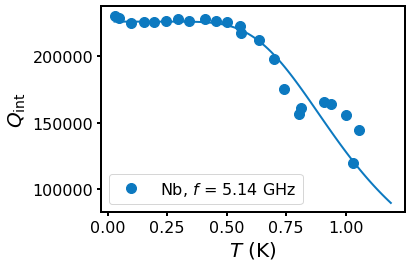

In [5]:
def func_qint_qp(T, delta, Qi, Q0, f):
    kb = 8.617e-5
    h = 4.136e-15
    Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))
    Qint = 1/(1/Qi +1/(Qqp))
    return Qint

def make_combined_plot_qi(FILES, mark = True):
    y_label=r'$Q_\mathrm{int}$'  
    fig, ax = rf.make_plot_pre('$T$ (K)', y_label, xscale = 'linear', figsize = (6,4))
    for i, f in enumerate(FILES):
        results = rf.proc_csv(f)
        photon, power, qi_diacorr, qi_diacorr_err, qc, qc_err, ql, ql_err, freq, freq_err = rf.get_results(results, 3000000) 
        power, qi_diacorr, qi_diacorr_err = zip(*sorted(zip(power, qi_diacorr, qi_diacorr_err)))
        bounds = ([150e-6, 0,  0, freq[0]-.0000001], [250e-6, np.inf, np.inf, freq[0]+.00001])
        popt, pcov = curve_fit(func_qint_qp, power,qi_diacorr,
                            p0 = [210e-6, qi_diacorr[0], 1, freq[0]],
#                             bounds=bounds,
                            maxfev = 1000000000
                           )
        if mark:
            markers = ['o' * len(marker_list) for marker_list in FILES]
        perr = np.sqrt(np.diag(pcov))
        ax.errorbar(np.array(power[0:-2]),qi_diacorr[0:-2],
                    linestyle = 'None',
                    color=line_colors[i],
                    marker = 'o', 
                    label = 'Nb, $f$ = '+str(round(freq[0]*1e-9,2))+r' GHz'
                    
#                     label = r'$\alpha$ = '+str(round(popt[0]*100, 2))
                   )


        x = np.linspace(power[0], power[-1], 100)
        plt.plot(x, (func_qint_qp(x, *popt)), color = line_colors[i], 
                )
    plt.legend()
    fig.tight_layout()
    plt.savefig(f'{root}/{sample}/results/temp_qis_{file_num}.pdf', format = 'pdf')

    return fig, ax

make_combined_plot_qi(FILES)